# Messtechnik HS2021 - Tutorial 8

## Aufgabe 1: Fredholmintegral und Tikhonov-Regularisierung
---------
Abstandsmessungen zwischen zwei paramagnetischen Zentren (Elektronenspins mit $S = 1/2$) werden in der EPR-Spektroskopie mittels der DEER-Pulssequenz gemacht. Ein Fredholmintegral erster Ordnung beschreibt das experimentell gemessene Signal

$$ S(t) = \int_0^{\rm t_{max}} K(t,r) P(r) dr $$

wobei $K(t,r)$ das dipolare Kernel ist, welches das Zeitsignal mit der Abstandsverteilung $P(r)$ verbindet. In der Realität, sind das exprimentelle Signal $\mathbf{S}$ und die Abstandsverteilung $\mathbf{P}$ Vektoren der Länge $n$ und $m$. Das dipolare Kernel $\mathrm{K}$ ist folglich eine Matrix mit der Dimension $ m \times n $. Das Zeitsignal wird somit als lineare Matrixoperation beschrieben:

$$ \mathbf{S} = \mathrm{K} \mathbf{P} $$


---------

### 1a)
Importieren Sie das package `deerlab` und laden Sie die experimentellen Zeitachse und Daten, indem Sie die Datei `DEER_signal.npz` mit der Numpyfunktion `load()` verwenden.

In [237]:
import numpy as np
import deerlab as dl

data = np.load('DEER_signal.npz')
t    = data['t']
S    = data['S']

### 1b)
Definieren Sie eine linear Distanzachse $\mathrm{r}$ im Bereich $[1.5,10]\, {\rm nm}$ mit gleicher Anzahl Punkte wie $t$ und berechnen Sie mit der Deerlab-Funktion `dipolarkernel()` das passende dipolare Kernel $\mathbf{K}$ für die Zeitachse $\mathbf{t}$ und Distanzachse $\mathbf{r}$.


In [238]:
r = np.linspace(1.5,10,251)
K = dl.dipolarkernel(t,r)

### 1c)
Berechnen Sie die Konditionszahl der dipolaren Kernelmatrix $\mathbf{K}$ und kommentieren Sie das Resultat in Bezug auf das weitere Fittingvorgehen.

In [239]:
cond = np.linalg.cond(K)
print(cond)

7.687130403858373e+18


<u>Lösung:</u>
Für ein well-conditioned Matrix ist die Konditionszahl nahe $1$. In diesem Fall kann das Inversionsproblem eines Fredholmintegrals erster Ordnung über die Gleichung

$$ \mathbf{P} = \mathbf{K}^{-1} \mathbf{S} $$
gelöst werden.

Für eine ill-conditioned Matrix ( $\text{cond(} \mathrm{K}) \neq 1$ ) ist die Lösung des Inversionsproblems nicht direkt möglich, sondern nur durch alternative Methoden, wie z.B. Tikhonov-Regularisierung, die die Lösung stabilisieren.

### 1d)
Berechnen Sie die Abstandsverteilung $\mathbf{P}$ durch Inversion der Kernelmatrix anhand der Gleichung:

$$ \mathbf{P} = \mathbf{K}^{-1} \mathbf{S} $$

Stellen Sie das Signal und die erhaltene Abstandsverteilung graphisch dar. Kommentieren Sie das Resultat der Abstandsverteilung und vergleichen Sie es mit der realen Abstandsverteilung ($\mathbf{r}_\text{truth}$, $\mathbf{P}_\text{truth}$), welche Sie auch in `DEER_signal.npz` als Variablen r und P finden.

(-1.0, 5.0)

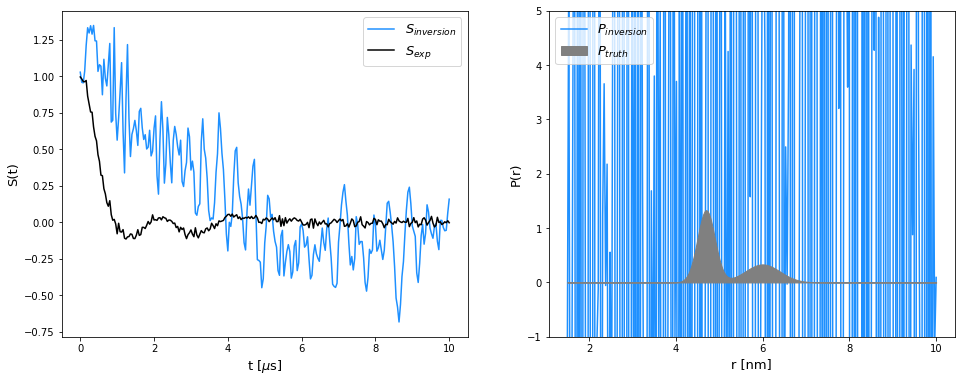

In [240]:
# Matrixinversion
Kinv = np.linalg.inv(K)
Pinv = S@Kinv

# Normalisierung (siehe Paper: 10.1039/C9CP06111H)
Pinv = Pinv/(sum(Pinv))/(r[1]-r[0])

# Rückwärtsfit Zeitsignal
Sinv = K@Pinv

rtruth = data['r']
Ptruth = data['P']

# Plot
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,Sinv,color='dodgerblue')
plt.plot(t,S,'k')
plt.xlabel('t [$\\mu$s]',fontsize=13)
plt.ylabel('S(t)',fontsize=13)
plt.legend(['$S_{inversion}$','$S_{exp}$'],fontsize=13)

plt.subplot(122)
plt.plot(r,Pinv,color='dodgerblue',zorder=1)
plt.fill_between(rtruth,np.zeros_like(Ptruth),Ptruth,color='grey',zorder=2)
plt.xlabel('r [nm]',fontsize=13)
plt.ylabel('P(r)',fontsize=13)
plt.legend(['$P_{inversion}$','$P_{truth}$'],fontsize=13);
plt.ylim((-1,5))

### 1e)
Finden Sie nun mit Hilfe der Tikhonov-Regularisierung 

$$ \mathbf{P}_\text{opt} = \text{argmin}\left\{ \frac{1}{2} ||\mathbf{K}\mathbf{P} - \mathbf{S}||_2^2 + \frac{\alpha^2}{2} || \mathbf{LP} ||_2^2 \right\} $$

eine optimale Lösung für den Fit des experimentelle Signal, um die richtige Abstandsverteilung herauszufinden.
Der Regularisierungsparameter $\alpha$ wägt die Übereinstimmung der Daten mit dem Fit mit dem Glätte-Penalty

($||\mathbf{LP}||_2^2$) ab.
Je grösser $\alpha$ desto mehr wird das Glättekriterium berücksichtigt und je kleiner $\alpha$ desto grösser die Datenübereinstimmung mit dem Fit.

Verwenden Sie für das Datenfitting und Herausfinden der Abstandsverteilung die Funktion `fitregmodel()` von `deerlab`. Probieren Sie unterschiedliche Regularisierungsparameter $\alpha$ zwischen $10^{-5}$ und $10$ aus und kommentieren Sie den Einfluss auf den Signalfit wie auch auf die resultierene Abstandsverteilung.

*Hinweis*: 
Verwenden Sie `help()` um die nötigen Inputs für die `fitregmodel`-Funktion herauszufinden. Verwenden Sie `regparam='tikhonov'` um die Tikhonov-Regularisierung zu wählen und geben Sie der Funktion $\alpha$ über `regparam=` weiter.



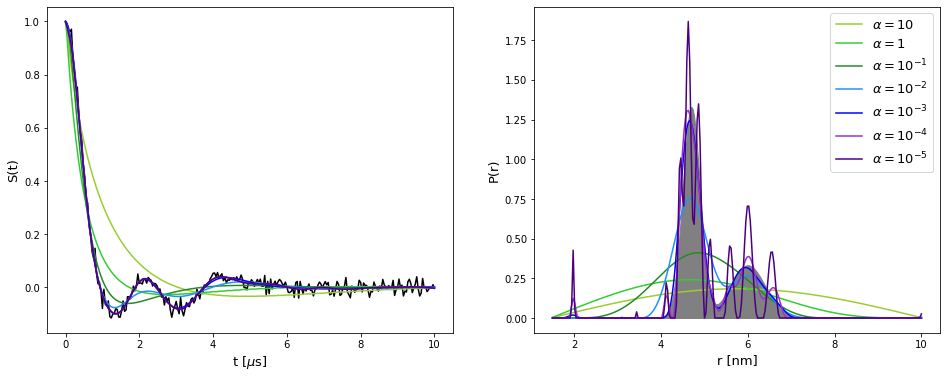

In [241]:
# Regularisierungsparameter
alpha = [10**1,10**0,10**-1,10**-2,10**-3,10**-4,10**-5]

# Plotparameter
legtext = ['$\\alpha = 10$','$\\alpha = 1$','$\\alpha = 10^{-1}$','$\\alpha = 10^{-2}$','$\\alpha = 10^{-3}$','$\\alpha = 10^{-4}$','$\\alpha = 10^{-5}$']
colors  = ['yellowgreen','limegreen','forestgreen','dodgerblue','blue','darkorchid','indigo']


plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,S,'k')
plt.xlabel('t [$\\mu$s]',fontsize=13)
plt.ylabel('S(t)',fontsize=13)

plt.subplot(122)
plt.fill_between(rtruth,np.zeros_like(Ptruth),Ptruth,color='grey')
plt.xlabel('r [nm]',fontsize=13)
plt.ylabel('P(r)',fontsize=13)

for k in range(len(alpha)):

    fit  = dl.fitregmodel(S,K,r,regtype='tikhonov',regparam=alpha[k])
    Pfit = fit.P
    Sfit = K@Pfit

    plt.subplot(121)
    plt.plot(t,Sfit,color=colors[k])

    plt.subplot(122)
    plt.plot(r,Pfit,color=colors[k])
    plt.legend(legtext,fontsize=13)

### Zusatz: 
Um eine gute Wahl für den Regularisierungsparameter $\alpha$ zu treffen gibt es unterschiedliche Auswahlkriterien wie AIC, BIC, etc.
Hier zeigen wir Ihnen die Unterschiede vom AIC, LR und srGCV Auswahlkriterium

Mehr Informationen zu Auswahlskriterien für die Auswertung von DEER-Messungen in der EPR finden Sie in den folgenden Papers:
- [Journal of Magnetic Resonance 288 (2018) 58–68](10.1016/j.jmr.2018.01.021)
- [Journal of Magnetic Resonance 300 (2019) 28–40](10.1016/j.jmr.2019.01.008)


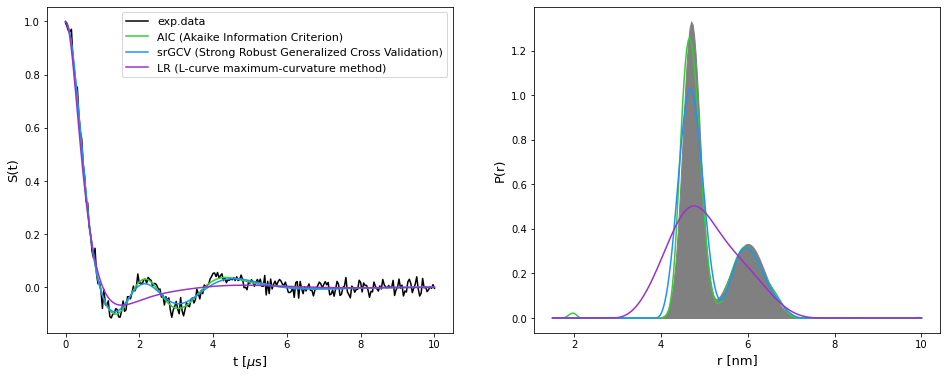

In [242]:
# Auswahlkriterium für Regularisierungsparameter
regparam = ['aic','srgcv','lr']

# Plotparameter
legtext = ['exp.data','AIC (Akaike Information Criterion)','srGCV (Strong Robust Generalized Cross Validation)','LR (L-curve maximum-curvature method)']
colors  = ['limegreen','dodgerblue','darkorchid']


plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(t,S,'k')
plt.xlabel('t [$\\mu$s]',fontsize=13)
plt.ylabel('S(t)',fontsize=13)

plt.subplot(122)
plt.fill_between(rtruth,np.zeros_like(Ptruth),Ptruth,color='grey')
plt.xlabel('r [nm]',fontsize=13)
plt.ylabel('P(r)',fontsize=13)

for k in range(len(regparam)):

    fit  = dl.fitregmodel(S,K,r,regtype='tikhonov',regparam=regparam[k])
    Pfit = fit.P
    Sfit = K@Pfit

    plt.subplot(121)
    plt.plot(t,Sfit,color=colors[k])
    plt.legend(legtext,fontsize=11,loc=1)

    plt.subplot(122)
    plt.plot(r,Pfit,color=colors[k])
    

## Aufgabe 2: Lorentzverteilter stochastischer Prozess
---------

Bei einem stochastischen Prozess ist das Ergebnis einer Messung nicht vorhersehbar. Trotzdem ist es wichtig Informationen über diesen stochastischen Prozess zu gewinnen, indem man charakteristische Grössen wie die Wahrscheinlichkeitsdichtefunktion und die spektrale Leistungsdichte betrachtet. Auch Autokorrelation und Kreuzkorrelation sind wichtige Hilfsmittel um das Signal zu charakterisieren und am Ende besser zu verstehen.

---------

### 2a)
Nehmen Sie an ein stochastischer Prozess $Y$ mit den Werten $y$ sei unkorreliert und lorentzverteilt mit der Wahrscheinlichkeitsdichtefunktion:
$$ q(y) = \frac{\beta}{\pi \left(\beta^2 + y^2 \right) } $$

Generieren Sie aus $N = 10^5$ gleichverteilten Zufallszahlen $x$ (siehe `numpy.random.rand`), mit der Wahrscheinlichkeitdichtefunktion-Eigenschaft 

$$ p(x)dx = dx \,\,\,\,\,\,\,\,{\rm wenn} \,\,\,0 < x < 1 ,$$ 

lorenztverteilte Zufallszahlen $y$.

Stellen Sie die Zufallszahlen $x$ und $y$ in Abhängigkeit von $N$ graphisch dar.

*Hinweis*: Verwenden Sie, um die Zufallsvariabel $y(x)$ aus $p(x)$ und $q(y)$ zu berechnen, die folgende mathematische Formel:
$$ p(x) \frac{dx}{dy} = q(y) $$

<u>Lösung:</u>
Die mathematische Formel vereinfacht sich nach einsetzen von $p(x)$ und $q(y)$ zu:
$\begin{align}
\frac{dx}{dy} &= \frac{\beta}{\pi \left(\beta^2 + y^2 \right) } \\
dx &= \frac{\beta}{\pi \left(\beta^2 + y^2 \right) } dy \\
\int 1\, dx &= \int \frac{\beta}{\pi \left(\beta^2 + y^2 \right) } dy \\
\end{align}$



In [243]:
import sympy as sp
from sympy.solvers.solvers import solve
from IPython.display import display, Math

beta = sp.Symbol('\\beta')
pi   = sp.Symbol('\\pi')
x = sp.Symbol('x')
y = sp.Symbol('y')
 
left  = sp.Integral(1,x)
right = sp.Integral(beta/(pi*(beta**2 + y**2)),y)
right = sp.simplify(right)
yofx  = solve(left-right,y)
display(Math(str(yofx)))

<IPython.core.display.Math object>

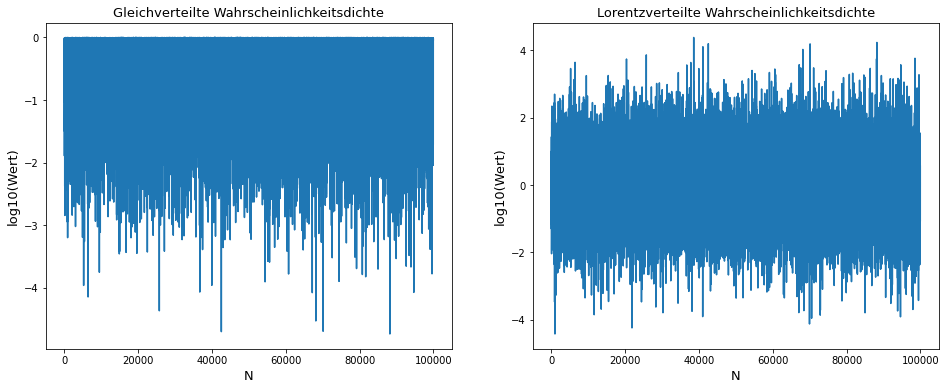

In [244]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

# Lorentzverteilung Parameter
N = 10**5
β = 1

# Generiere gleichverteilte Random Zahlen zwischen 0-1
uniform = np.random.rand(N)

# Generiere lorentzverteilte Random Zahlen aus x (=gleichverteilt)
lorentz = -β/np.tan(m.pi*uniform)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(np.log10(uniform))
plt.xlabel('N',fontsize=13)
plt.ylabel('log10(Wert)',fontsize=13)
plt.title('Gleichverteilte Wahrscheinlichkeitsdichte',fontsize=13)
plt.subplot(122)
plt.plot(np.log10(np.abs(lorentz)))
plt.xlabel('N',fontsize=13)
plt.ylabel('log10(Wert)',fontsize=13)
plt.title('Lorentzverteilte Wahrscheinlichkeitsdichte',fontsize=13);

### 2b)
Zeigen Sie anhand von Histogrammen (siehe `matlibplot.pyplot.hist()`), dass die Verteilung der Zufallszahlen $x$ und $y$ wirklich den Wahrscheinlichkeitsdichtefunktionen $p(x)$ und $q(y)$ folgt.

*Hinweis*: Die gleichverteilte Wahrscheinlichkeitsdichtefunktion $p(x)$ kann beschrieben werden als:
$$ p(x) = \frac{1}{B-A} \,\,\,\,\,\,\,\,{\rm wenn} \,\,\,A < x < B .$$ 

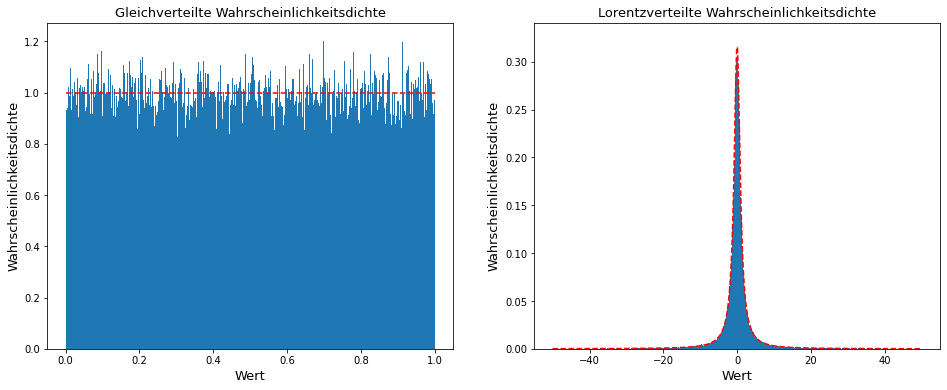

In [245]:
# Definiere Werte für Histogram-Bins
binsuni = np.linspace(0,1,500)
binslor = np.linspace(-50,50,500)

# Generiere die theoretischen Wahrscheinlichkeitsdichtefunktionen im bin-Bereich
pdfuni  = np.ones_like(binsuni)
pdflor  = β/(m.pi*(β**2 + binslor**2))


plt.figure(figsize=(16,6))
plt.subplot(121)
plt.hist(uniform,binsuni,density=True)
plt.plot(binsuni,pdfuni,'r--')
plt.xlabel('Wert',fontsize=13)
plt.ylabel('Wahrscheinlichkeitsdichte',fontsize=13)
plt.title('Gleichverteilte Wahrscheinlichkeitsdichte',fontsize=13)
plt.subplot(122)
plt.hist(lorentz,binslor,density=True)
plt.plot(binslor,pdflor,'r--')
plt.xlabel('Wert',fontsize=13)
plt.ylabel('Wahrscheinlichkeitsdichte',fontsize=13)
plt.title('Lorentzverteilte Wahrscheinlichkeitsdichte',fontsize=13);

### 2c)
Die Autokorrelation kann als Faltung eines Signals mit sich selbst betrachtet werden. Schreiben Sie eine Funktion, die über das Faltungstheorem die Autokorrelation eines Zeitsignals berechnet. 

In [246]:
from numpy.fft import fft,ifft,fftshift,fftfreq

def autocorr_fcn(x):

    X     = fft(x)
    Xstar = np.ndarray.conjugate(X)
    Sxx   = X*Xstar
    Rxx   = ifft(Sxx)

    return Rxx,Sxx


### 2d)
Importieren Sie die Zeitachse und das zu analysierende Signal aus dem File `timesignal.npz`, indem Sie die `numpy.load()` verwenden.
Probieren Sie mit Hilfe der Fourier Transformation und der Autokorrelationsfunktion die 2 Frequenzen des Signals herauszufinden.

In [247]:
# Generieren timesignal.npz
frq1 = 2.25
frq2 = 3.34
sig  = 0.13
frac = 0.05
T2   = 8
t    = np.linspace(0,10,2048)
dt   = t[1]-t[0]

np.random.seed(2)
out = frac*(np.exp(1j*2*m.pi*frq1*t)+np.exp(1j*2*m.pi*frq2*t))*np.exp(-t/T2) + np.random.normal(0,sig,len(t))
out = out/np.amax(out)
np.savez('timesignal.npz',t=t,signal=out)

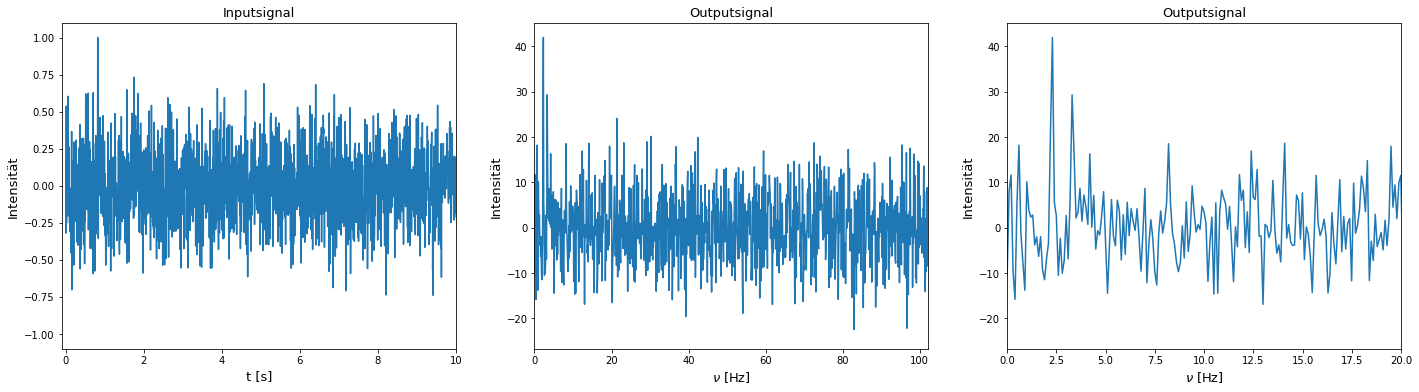

In [248]:
# Daten importieren
data = np.load('timesignal.npz')
t    = data['t']
signal = data['signal']

# Frequenzachse und Spektrum
frqax = fftshift(fftfreq(len(t),d=dt))
Sraw  = fftshift(fft(signal))

# Plot
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.plot(t,np.real(out))
plt.xlabel('t [s]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.xlim((-0.1,max(t)))
plt.ylim((-1.1,1.1))
plt.title('Inputsignal',fontsize=13)

plt.subplot(132)
plt.plot(frqax,np.real(Sraw))
plt.xlim((0,max(frqax)))
plt.xlabel('$\\nu$ [Hz]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.title('Outputsignal',fontsize=13)

plt.subplot(133)
plt.plot(frqax,np.real(Sraw))
plt.xlim((0,20))
plt.xlabel('$\\nu$ [Hz]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.title('Outputsignal',fontsize=13);


[2.1989257812500003, 3.298388671875]


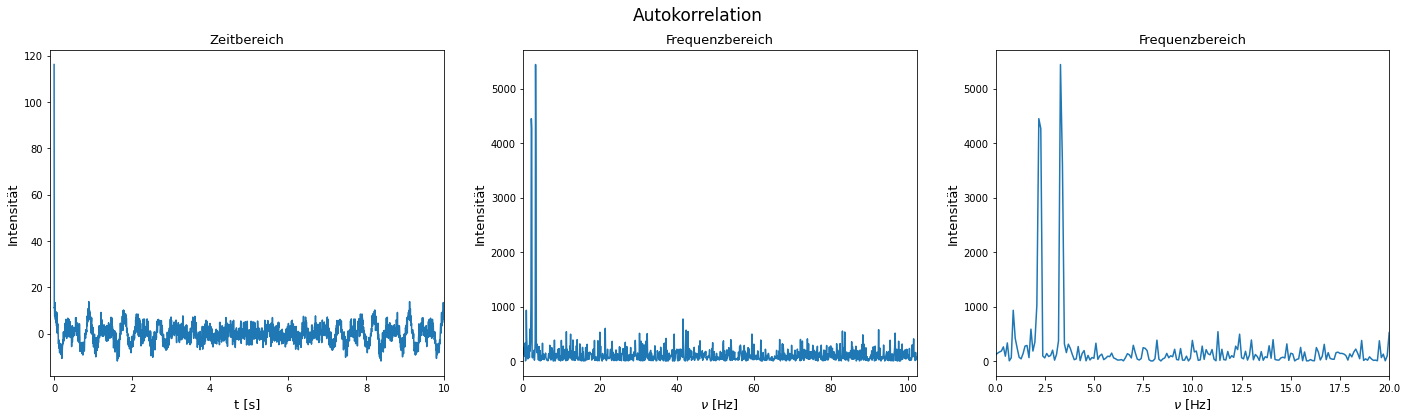

In [249]:
# Berechnung von Autokorrelatin
Rxx,Sxx = autocorr_fcn(out)
Sxx     = fftshift(Sxx)

# Plot Input Autokorrelation
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.plot(t,np.real(Rxx))
plt.xlim((-0.1,max(t)))
plt.xlabel('t [s]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.title('Zeitbereich',fontsize=13)

plt.subplot(132)
plt.plot(frqax,np.real(Sxx))
plt.xlabel('$\\nu$ [Hz]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.xlim((0,max(frqax)))
plt.title('Frequenzbereich',fontsize=13)
plt.suptitle('Autokorrelation',fontsize=17)

plt.subplot(133)
plt.plot(frqax,np.real(Sxx))
plt.xlabel('$\\nu$ [Hz]',fontsize=13)
plt.ylabel('Intensität',fontsize=13)
plt.xlim((0,20))
plt.title('Frequenzbereich',fontsize=13)
plt.suptitle('Autokorrelation',fontsize=17);

part1 = Sxx[frqax <=2.8]
frqax1  = frqax[frqax <=2.8]
part2 = Sxx[frqax > 2.8]
frqax2  = frqax[frqax > 2.8]
frq1 = frqax1[part1 == max(part1)]
frq2 = frqax2[part2 == max(part2)]

print([frq1[0],frq2[0]])